In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chips-customer-analysis-plan-forage/QVI_purchase_behaviour.csv
/kaggle/input/chips-customer-analysis-plan-forage/QVI_transaction_data.csv
/kaggle/input/chips-customer-analysis-plan-forage-trailcontrol/QVI_data.csv


In [2]:
# Load datasets
qvi_data = pd.read_csv('/kaggle/input/chips-customer-analysis-plan-forage-trailcontrol/QVI_data.csv')

In [3]:
qvi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
# Displayng the first few rows of dataset
qvi_data_head = qvi_data.head()
qvi_data_shape = qvi_data.shape

qvi_data_head, qvi_data_shape

(   LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
 0            1000  2018-10-17          1       1         5   
 1            1002  2018-09-16          1       2        58   
 2            1003  2019-03-07          1       3        52   
 3            1003  2019-03-08          1       4       106   
 4            1004  2018-11-02          1       5        96   
 
                                 PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
 0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
 1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
 2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
 3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
 4          WW Original Stacked Chips 160g         1        1.9        160   
 
         BRAND              LIFESTAGE PREMIUM_CUSTOMER  
 0     NATURAL  YOUNG SINGLES/COUPLES          Premium  
 1         RRD  YOUNG SINGLES/COUPLE

# APPROACH:-
# 1. Control Store Selection: Selecting control stores based on pre-trial metrics.
# 2. Trial vs Control Comparison: Comparing trial stores with their control stores during the trial period.
# 3. Visualizations and Statistical Tests: Generating visualizations and conducting significance tests.

1. Control Store Selection: Selecting control stores based on pre-trial metrics.

In [5]:
# Convert 'DATE' column to datetime if not already
qvi_data['DATE'] = pd.to_datetime(qvi_data['DATE'])

In [6]:
# Convert trial start and end dates to datetime objects
trial_start_date = pd.to_datetime('2019-02-01') 
trial_end_date = pd.to_datetime('2019-04-30')

In [7]:
# Defining pre-trial period (adjust based on actual trial start date)
pre_trial_period = qvi_data[qvi_data['DATE'] < trial_start_date]

In [8]:
# Calculate monthly metrics: total sales, customers, transactions per customer
def calculate_metrics(data):
    metrics = data.groupby(['STORE_NBR', data['DATE'].dt.to_period('M')]).agg(
        total_sales=('TOT_SALES', 'sum'),
        num_customers=('LYLTY_CARD_NBR', 'nunique'),
        transactions_per_customer=('TXN_ID', 'count')
    ).reset_index()
    return metrics

# Calculate metrics for pre-trial period
pre_trial_metrics = calculate_metrics(pre_trial_period)

# Function to calculate Euclidean distance between trial and control store metrics
def find_control_store(trial_store_metrics, all_store_metrics):
    distances = {}

    # Loop through all stores to calculate distances
    for store in all_store_metrics['STORE_NBR'].unique():
        if store != trial_store_metrics['STORE_NBR'].unique()[0]:
            # Filter metrics for the control store
            control_store_metrics = all_store_metrics[all_store_metrics['STORE_NBR'] == store]

            # Align both trial and control store metrics by month (matching DATE period)
            merged_metrics = pd.merge(trial_store_metrics, control_store_metrics, on='DATE', suffixes=('_trial', '_control'))

            # Calculate the Euclidean distance across months for the relevant metrics
            distance = 0
            for _, row in merged_metrics.iterrows():
                trial_vector = [row['total_sales_trial'], row['num_customers_trial'], row['transactions_per_customer_trial']]
                control_vector = [row['total_sales_control'], row['num_customers_control'], row['transactions_per_customer_control']]
                
                # Sum the Euclidean distances across each month
                distance += euclidean(trial_vector, control_vector)

            # Store the distance for the control store
            distances[store] = distance

    # Return store with the smallest aggregated distance
    control_store = min(distances, key=distances.get)
    return control_store

# Finding control store for trial store 86
trial_store_86 = pre_trial_metrics[pre_trial_metrics['STORE_NBR'] == 86]
control_store_86 = find_control_store(trial_store_86, pre_trial_metrics)

print(f"Control store for trial store 86: {control_store_86}")

# Example: Find control store for trial store 77
trial_store_77 = pre_trial_metrics[pre_trial_metrics['STORE_NBR'] == 77]
control_store_77 = find_control_store(trial_store_77, pre_trial_metrics)

print(f"Control store for trial store 77: {control_store_77}")

# Example: Find control store for trial store 88
trial_store_88 = pre_trial_metrics[pre_trial_metrics['STORE_NBR'] == 88]
control_store_88 = find_control_store(trial_store_88, pre_trial_metrics)

print(f"Control store for trial store 88: {control_store_88}")

Control store for trial store 86: 155
Control store for trial store 77: 233
Control store for trial store 88: 237


2. Trial vs Control Comparison: Comparing trial stores with their control stores during the trial period.

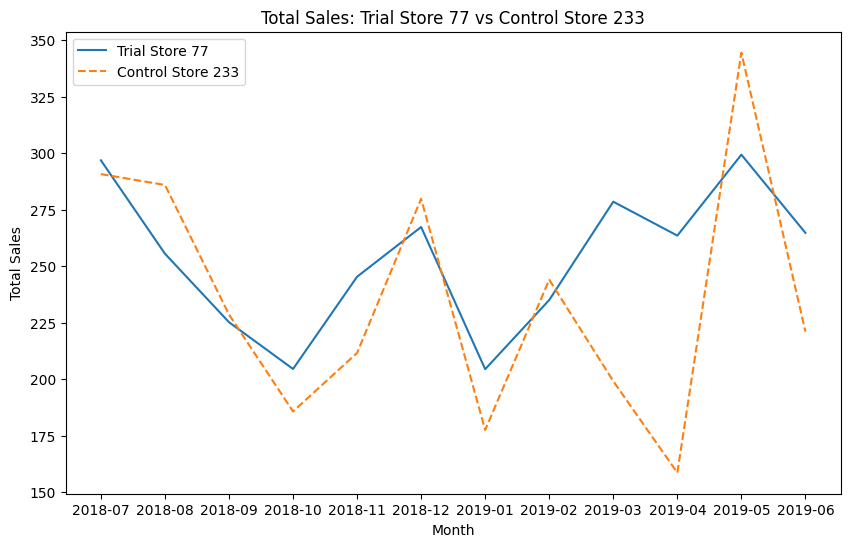

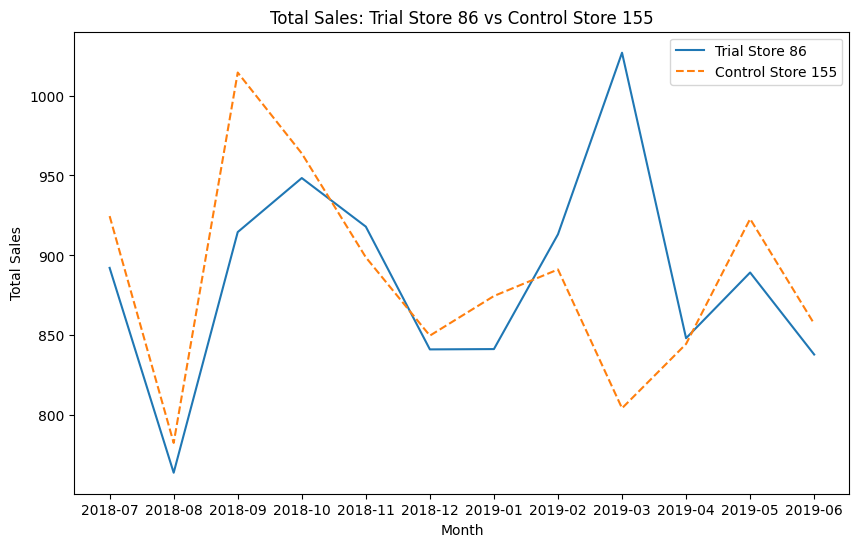

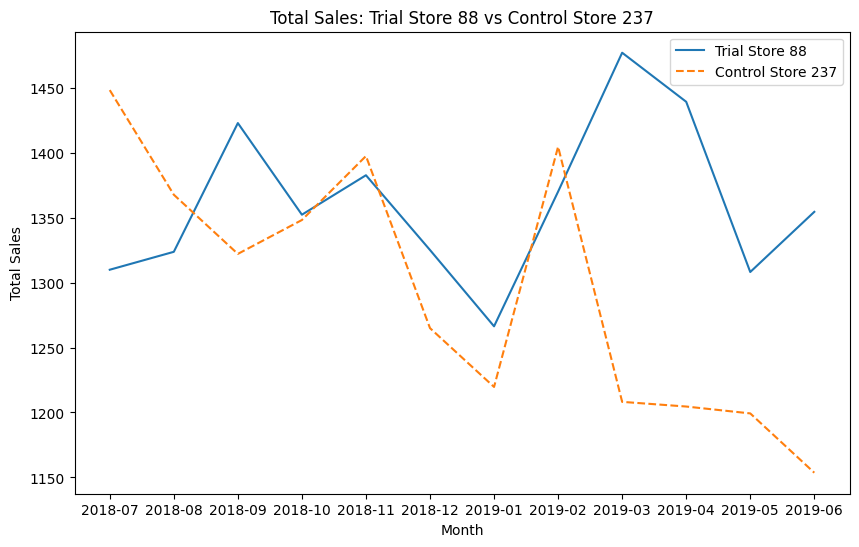

In [9]:
# Function to compare trial and control store metrics
def compare_trial_and_control(trial_store, control_store, data):
    # Filter the data for the trial and control stores
    trial_store_data = data[data['STORE_NBR'] == trial_store]
    control_store_data = data[data['STORE_NBR'] == control_store]
    #trial_period = data[(data['DATE'] >= trial_start_date) & (data['DATE'] <= trial_end_date)]
    
    # Calculate metrics for both stores
    trial_metrics = calculate_metrics(trial_store_data)
    control_metrics = calculate_metrics(control_store_data)
    
    # Convert 'DATE' to string to avoid 'Period' issues
    trial_metrics['DATE'] = trial_metrics['DATE'].astype(str)
    control_metrics['DATE'] = control_metrics['DATE'].astype(str)
    
    # Plot comparison
    plt.figure(figsize=(10,6))
    plt.plot(trial_metrics['DATE'], trial_metrics['total_sales'], label=f'Trial Store {trial_store}')
    plt.plot(control_metrics['DATE'], control_metrics['total_sales'], label=f'Control Store {control_store}', linestyle='--')
    plt.title(f'Total Sales: Trial Store {trial_store} vs Control Store {control_store}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()
    
    return trial_metrics, control_metrics

# Compare trial store 77 with its control store
trial_metrics_77, control_metrics_77 = compare_trial_and_control(77, control_store_77, qvi_data)

# Compare trial store 86 with its control store
trial_metrics_86, control_metrics_86 = compare_trial_and_control(86, control_store_86, qvi_data)

# Compare trial store 88 with its control store
trial_metrics_88, control_metrics_88 = compare_trial_and_control(88, control_store_88, qvi_data)



3. Visualizations and Statistical Tests: Generating visualizations and conducting significance tests.

T-test result: t-statistic = 0.9679236368390388, p-value = 0.34360373343122186
The difference in total sales is not statistically significant.


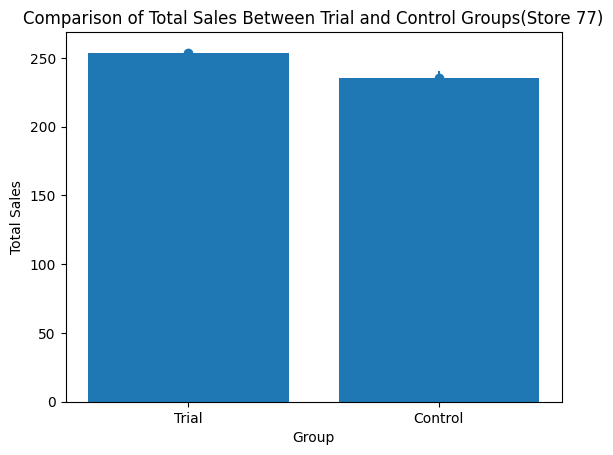

In [10]:
# TRIAL STORE 77
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Perform t-test to check if sales during the trial are significantly different
t_stat, p_value = ttest_ind(trial_metrics_77['total_sales'], control_metrics_77['total_sales'])

# Print the t-statistic and p-value
print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")

# Check the significance of the p-value
if p_value < 0.05:
    print("The difference in total sales is statistically significant.")
else:
    print("The difference in total sales is not statistically significant.")

# Create a bar plot to visualize the mean sales for each group
plt.bar(['Trial', 'Control'], [trial_metrics_77['total_sales'].mean(), control_metrics_77['total_sales'].mean()])
plt.xlabel('Group')
plt.ylabel('Total Sales')
plt.title('Comparison of Total Sales Between Trial and Control Groups(Store 77)')

# Add error bars representing standard errors
plt.errorbar(['Trial', 'Control'], [trial_metrics_77['total_sales'].mean(), control_metrics_77['total_sales'].mean()],
             yerr=[trial_metrics_77['total_sales'].std() / len(trial_metrics_77), control_metrics_77['total_sales'].std() / len(control_metrics_77)],
             fmt='o')

# Show the plot
plt.show()

T-test result: t-statistic = 0.019793022667677837, p-value = 0.9843869025850827
The difference in total sales is not statistically significant.


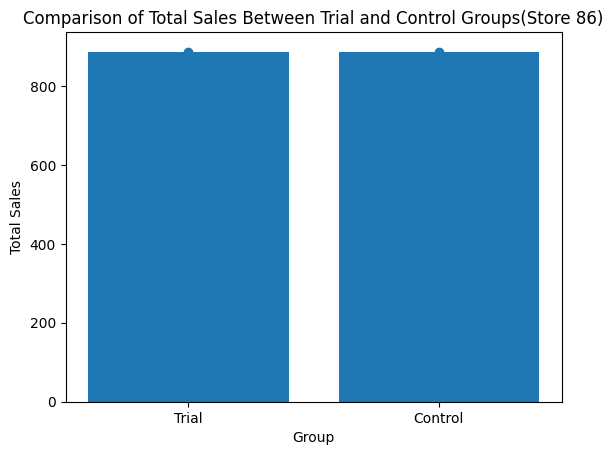

In [11]:
# TRIAL STORE 86
# Perform t-test to check if sales during the trial are significantly different
t_stat, p_value = ttest_ind(trial_metrics_86['total_sales'], control_metrics_86['total_sales'])

# Print the t-statistic and p-value
print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")

# Check the significance of the p-value
if p_value < 0.05:
    print("The difference in total sales is statistically significant.")
else:
    print("The difference in total sales is not statistically significant.")

# Create a bar plot to visualize the mean sales for each group
plt.bar(['Trial', 'Control'], [trial_metrics_86['total_sales'].mean(), control_metrics_86['total_sales'].mean()])
plt.xlabel('Group')
plt.ylabel('Total Sales')
plt.title('Comparison of Total Sales Between Trial and Control Groups(Store 86)')

# Add error bars representing standard errors
plt.errorbar(['Trial', 'Control'], [trial_metrics_86['total_sales'].mean(), control_metrics_86['total_sales'].mean()],
             yerr=[trial_metrics_86['total_sales'].std() / len(trial_metrics_86), control_metrics_86['total_sales'].std() / len(control_metrics_86)],
             fmt='o')

# Show the plot
plt.show()

T-test result: t-statistic = 1.9781599338138325, p-value = 0.06056801623928565
The difference in total sales is not statistically significant.


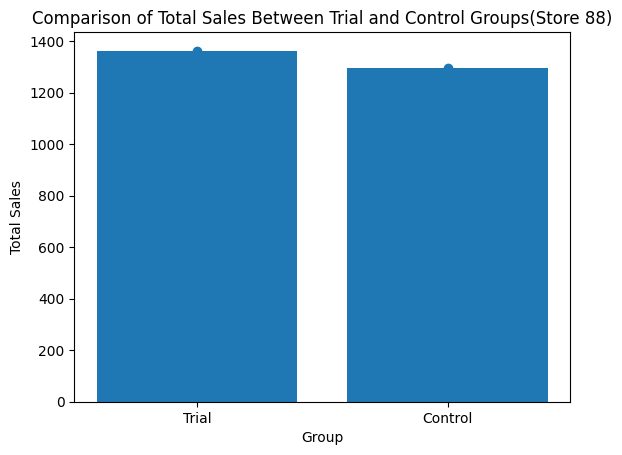

In [12]:
# TRIAL STORE 88
# Perform t-test to check if sales during the trial are significantly different
t_stat, p_value = ttest_ind(trial_metrics_88['total_sales'], control_metrics_88['total_sales'])

# Print the t-statistic and p-value
print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")

# Check the significance of the p-value
if p_value < 0.05:
    print("The difference in total sales is statistically significant.")
else:
    print("The difference in total sales is not statistically significant.")

# Create a bar plot to visualize the mean sales for each group
plt.bar(['Trial', 'Control'], [trial_metrics_88['total_sales'].mean(), control_metrics_88['total_sales'].mean()])
plt.xlabel('Group')
plt.ylabel('Total Sales')
plt.title('Comparison of Total Sales Between Trial and Control Groups(Store 88)')

# Add error bars representing standard errors
plt.errorbar(['Trial', 'Control'], [trial_metrics_88['total_sales'].mean(), control_metrics_88['total_sales'].mean()],
             yerr=[trial_metrics_88['total_sales'].std() / len(trial_metrics_88), control_metrics_88['total_sales'].std() / len(control_metrics_88)],
             fmt='o')

# Show the plot
plt.show()